In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import seaborn as sns
import pandas as pd
import os
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
analytics1 = load_json_as_dict(os.path.join('data/simulate_circuits/2025_01_28__21_36_14', 'analytics.json'))
config1 = load_json_as_dict(os.path.join('data/simulate_circuits/2025_01_28__21_36_14', 'config.json'))
analytics2 = load_json_as_dict(os.path.join('data/simulate_circuits/2025_01_29__14_52_44', 'analytics.json'))
config2 = load_json_as_dict(os.path.join('data/simulate_circuits/2025_01_29__14_52_44', 'config.json'))


In [56]:
r = np.array(analytics2['response_time_wrt_species-6'])[:, -1]
idxs = np.where(~np.isinf(r) & ~np.isnan(r) & (r < r[r < np.inf].max() * 0.9))[0]

interactions = np.load('data/simulate_circuits/2025_01_29__14_52_44/interactions.npy')
ys = np.load('data/simulate_circuits/2025_01_29__14_52_44/ys.npy')
ts = np.load('data/simulate_circuits/2025_01_29__14_52_44/ts.npy')
ts0 = np.load('data/simulate_circuits/2025_01_29__14_52_44/ts0.npy')
y00s = np.load('data/simulate_circuits/2025_01_29__14_52_44/y00s.npy')
y0m = np.load('data/simulate_circuits/2025_01_29__14_52_44/y0m.npy')

In [34]:
fn1 = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn2 = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
data1 = pd.read_csv(fn1)
data2 = pd.read_csv(fn2)
len(data1), len(data2)

/tmp/ipykernel_2288120/2486700094.py:4: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv(fn1)


(2583619, 600000)

In [127]:
n_species = config2['circuit_generation']['species_count']
data = pd.DataFrame.from_dict({k: np.array(v)[..., -n_species:].flatten() for k, v in analytics2.items()})
data['sample_name'] = np.repeat(np.array([f"{config2['system_type']}_{i}" for i in range(n_species)])[:, None],
                                repeats=len(data) // n_species, axis=1).T.flatten()
data['circuit_name'] = np.repeat(np.arange(len(data) // n_species), repeats=n_species)
data['mutation_name'] = 'ref_circuit'
data['mutation_num'] = 0
data['mutation_type'] = '[]'
data['mutation_positions'] = '[]'
data['path_to_template_circuit'] = ''
interactions_flat = jax.vmap(lambda x: x[np.triu_indices(n_species)])(interactions)
idxs = np.array(np.triu_indices(n_species)).T
idxs_same = np.where(idxs[:, 0] == idxs[:, 1])[0]
idxs_diff = np.where(idxs[:, 0] != idxs[:, 1])[0]
data['num_interacting'] = np.repeat((interactions_flat != 0)[:, idxs_diff].sum(axis=1), repeats=n_species)
data['num_self_interacting'] = np.repeat((interactions_flat != 0)[:, idxs_same].sum(axis=1), repeats=n_species)
for i, n in enumerate(get_true_interaction_cols(data1, 'energies', remove_symmetrical=True)):
    data[n] = np.repeat(interactions_flat[:, i], repeats=n_species)

In [135]:
def summarise_simulated_cicruits(analytics, config):
    n_species = config['circuit_generation']['species_count']
    data = pd.DataFrame.from_dict({k: np.array(v)[..., -n_species:].flatten() for k, v in analytics.items()})
    data['sample_name'] = np.repeat(np.array([f"{config['system_type']}_{i}" for i in range(n_species)])[:, None],
                                    repeats=len(data) // n_species, axis=1).T.flatten()
    data['circuit_name'] = np.repeat(np.arange(len(data) // n_species), repeats=n_species)
    data['mutation_name'] = 'ref_circuit'
    data['mutation_num'] = 0
    data['mutation_type'] = '[]'
    data['mutation_positions'] = '[]'
    data['path_to_template_circuit'] = ''
    interactions_flat = jax.vmap(lambda x: x[np.triu_indices(n_species)])(interactions)
    idxs = np.array(np.triu_indices(n_species)).T
    idxs_same = np.where(idxs[:, 0] == idxs[:, 1])[0]
    idxs_diff = np.where(idxs[:, 0] != idxs[:, 1])[0]
    data['num_interacting'] = np.repeat((interactions_flat != 0)[:, idxs_diff].sum(axis=1), repeats=n_species)
    data['num_self_interacting'] = np.repeat((interactions_flat != 0)[:, idxs_same].sum(axis=1), repeats=n_species)
    for ii, (i, j) in enumerate(idxs):
        data[f'energies_{i}-{j}'] = np.repeat(interactions_flat[:, ii], repeats=n_species)
    return data


from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
def save(returns_kwrgs, top_write_dir):
    for l, v in returns_kwrgs.items():
        ext = os.path.splitext(l)[1]
        if ext == '.npy':
            np.save(os.path.join(top_write_dir, l), v)
        elif ext == '.json':
            write_json(v, os.path.join(top_write_dir, l))
        else:
            print(f'Warning: could not save {l} of type {ext}')
    print(top_write_dir)


data = summarise_simulated_cicruits(analytics2, config2)
save({'tabulated_mutation_info.json': data}, '.')


.


In [47]:
data1['Log sensitivity'] = np.log10(data1['sensitivity_wrt_species-6'])
data2['Log sensitivity'] = np.log10(data2['sensitivity_wrt_species-6'])
data1['Log precision'] = np.log10(data1['precision_wrt_species-6'])
data2['Log precision'] = np.log10(data2['precision_wrt_species-6'])


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


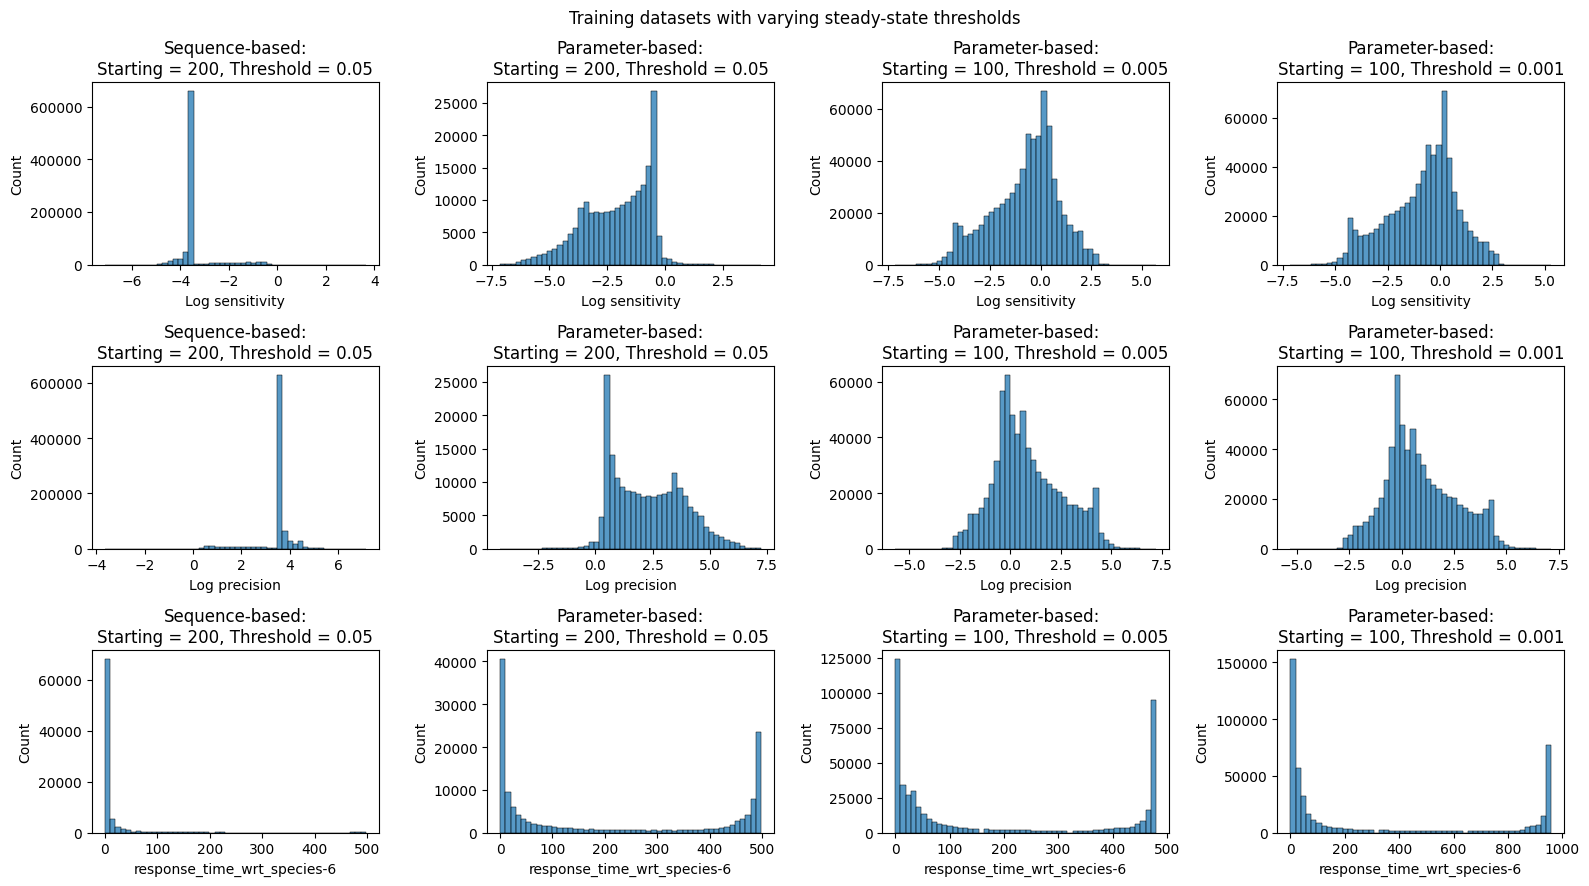

In [134]:
fig, axes = plt.subplots(3, 4, figsize=(4 * 4, 3*3))
for i, k in enumerate(['Log sensitivity', 'Log precision', 'response_time_wrt_species-6']):
    sns.histplot(data1[data1['sample_name'] == 'RNA_2'], x=k, bins=50, ax=axes[i, 0])
    axes[i, 0].set_title('Sequence-based:\nStarting = 200, Threshold = 0.05')
    sns.histplot(data2[data2['sample_name'] == 'RNA_2'], x=k, bins=50, ax=axes[i, 1])
    axes[i, 1].set_title('Parameter-based:\nStarting = 200, Threshold = 0.05')
    s = np.array(analytics1[k])[:, -1]
    sns.histplot(s, bins=50, ax=axes[i, 2])
    axes[i, 2].set_xlabel(k)
    axes[i, 2].set_title(f'Parameter-based:\nStarting = 100, Threshold = 0.005')
    s = np.array(analytics2[k])[:, -1]
    sns.histplot(s, bins=50, ax=axes[i, 3])
    axes[i, 3].set_xlabel(k)
    axes[i, 3].set_title(f'Parameter-based:\nStarting = 100, Threshold = {config2["simulation"]["threshold_steady_states"]}')
plt.suptitle('Training datasets with varying steady-state thresholds')
plt.tight_layout()



In [ ]:
idxs = np.where(~np.isinf(r) & ~np.isnan(r) & (r < r[r < np.inf].max() * 0.9))[0]


In [ ]:
# !pip install cairosvg
# !apt install libcairo2
import cairosvg

# Load the SVG file
svg_file_path = '../data/adaptation_m0_log_adaptation.svg'

# Convert SVG to PNG
png_file_path = svg_file_path.replace('svg', 'png')
cairosvg.svg2png(url=svg_file_path, write_to=png_file_path, output_width=500, output_height=500)

print(f'SVG file has been converted to PNG and saved at {png_file_path}')

